In [1]:
import lightkurve as lk
from scipy.ndimage import binary_dilation
import numpy as np
import matplotlib.pyplot as plt

In [2]:
target = 'HD 140283'

In [3]:
search = lk.search_targetpixelfile(target)
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 51,2022,SPOC,20,290565106,0.0
1,TESS Sector 51,2022,SPOC,120,290565106,0.0
2,TESS Sector 51,2022,TESS-SPOC,600,290565106,0.0


In [4]:
tpf = search[0].download()

In [5]:
lcsearch = lk.search_lightcurve(target)

In [6]:
lcsearch

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 51,2022,SPOC,20,290565106,0.0
1,TESS Sector 51,2022,SPOC,120,290565106,0.0
2,TESS Sector 51,2022,TESS-SPOC,600,290565106,0.0
3,TESS Sector 51,2022,QLP,600,290565106,0.0


In [7]:
spoc_lc = lcsearch[0].download()

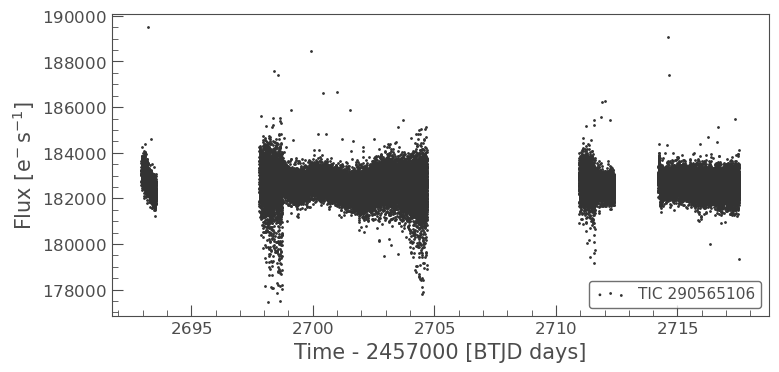

In [8]:
spoc_lc.scatter();

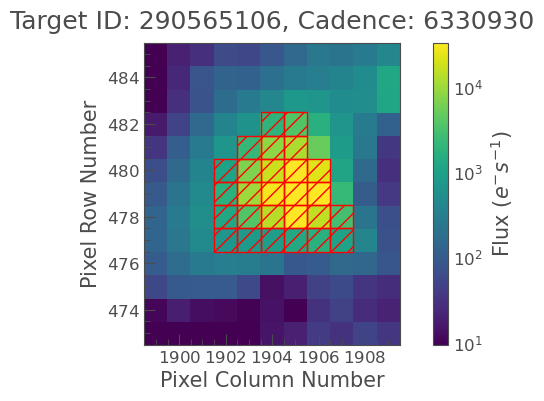

In [9]:
tpf.plot(scale='log',aperture_mask=tpf.pipeline_mask);

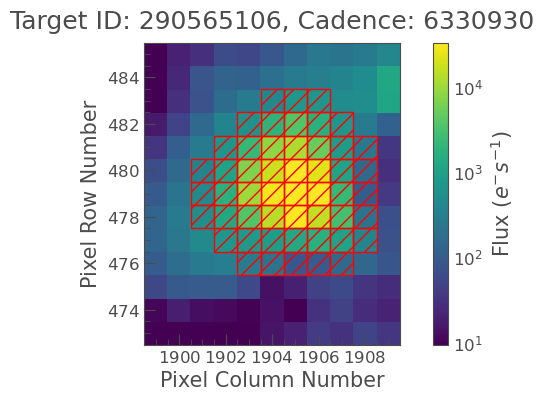

In [10]:
mask = tpf.create_threshold_mask(threshold=3)
mask = binary_dilation(mask,iterations=1)

tpf.plot(scale='log',aperture_mask=mask);

In [11]:
lc = tpf.to_lightcurve(aperture_mask = mask)

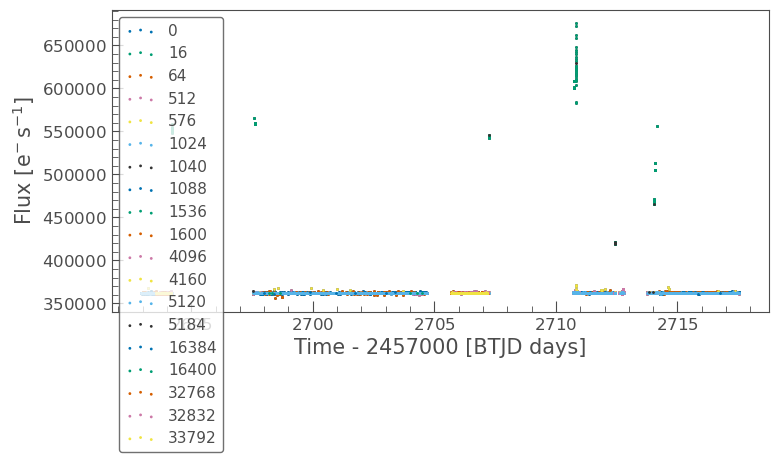

In [12]:
ax = lc.scatter(label='');
for flag in np.unique(lc.quality):
    m = lc.quality == flag
    lc[m].scatter(ax=ax, label=flag);

In [13]:
m = ((lc.quality & 16) == 0) & ((lc.quality & 64) == 0)

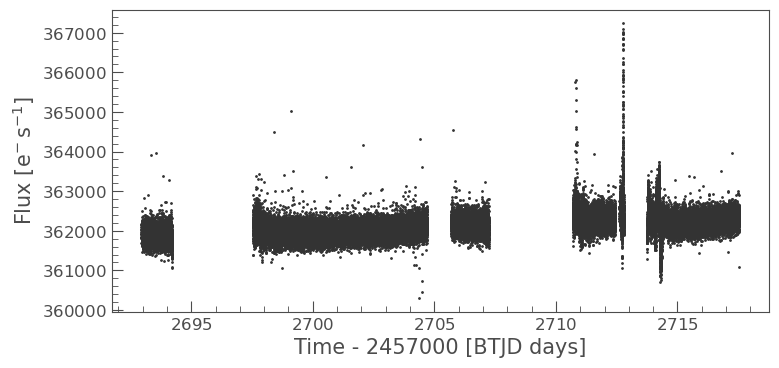

In [14]:
ax = lc[m].scatter(label='');

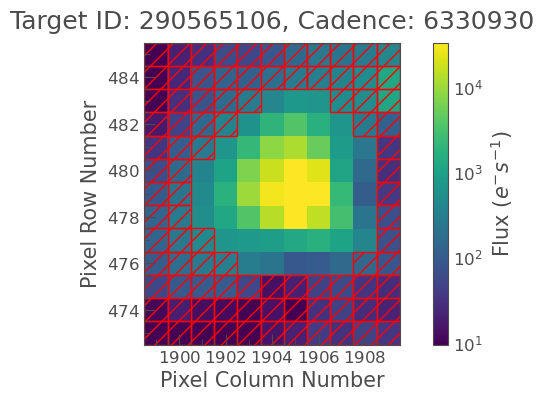

In [15]:
# Indentify NaN pixels
nanpixels = np.isnan(np.nanmean(tpf.flux,axis=0))

# Pixels that are neither in aperture mask or nan
outpixels = ~nanpixels & ~mask

tpf.plot(scale='log',aperture_mask=outpixels);

In [16]:
# Make regressors from outer pixels
regressors = tpf.flux[:,outpixels]

# Identify time steps where flux or flux error is NaN
nantimes = np.isnan(lc.flux_err) | np.isnan(lc.flux) | (np.sum(np.isnan(tpf.flux[:,~nanpixels]),axis=1) > 0)

# Also filter out bad cadences
nantimes = nantimes | ~m

# Only include time steps where flux error is ~Nan in regressors
regressors = regressors[~nantimes,:]

# Make design matrix from our regressors, taking 5 principal components, adding a constant
dm = lk.DesignMatrix(regressors, name = 'regressors').pca(5).append_constant()

# Make corrector object
corrector = lk.RegressionCorrector(lc[~nantimes])

# Correct light curve
lc = corrector.correct(dm)

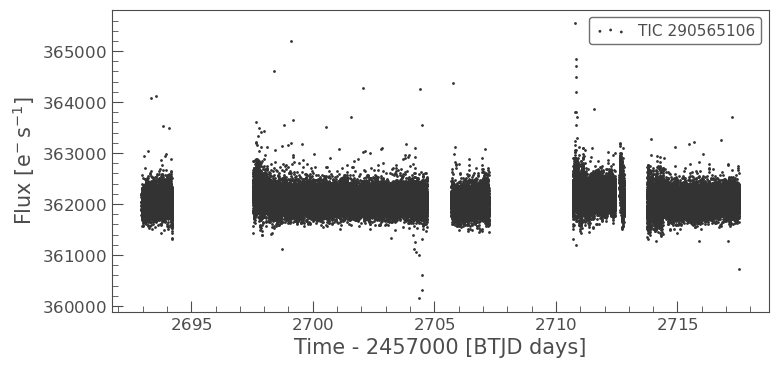

In [17]:
lc.scatter();

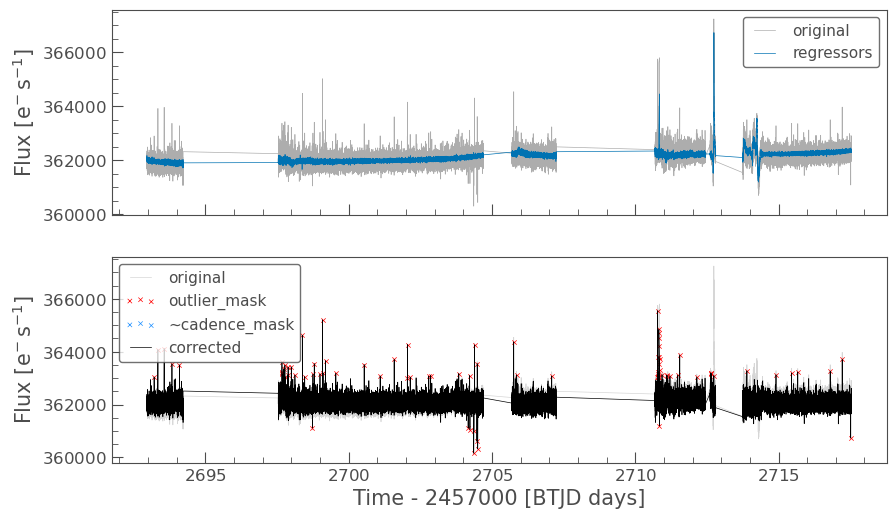

In [18]:
corrector.diagnose();

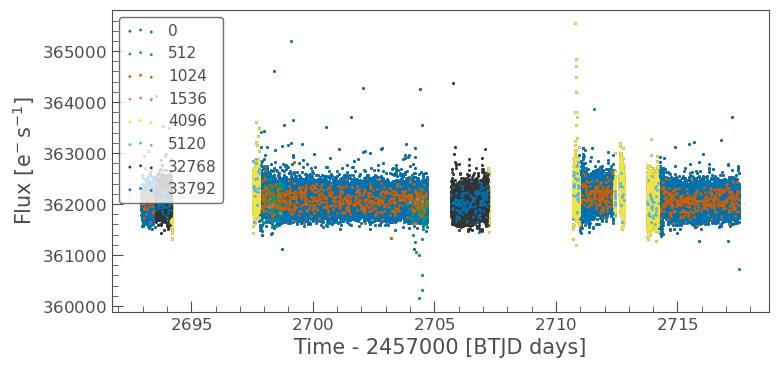

In [19]:
ax = lc.scatter(label='');
for flag in np.unique(lc.quality):
    m = lc.quality == flag
    lc[m].scatter(ax=ax, label=flag);

In [20]:
m = (lc.quality & 4096) == 0
lc = lc[m]

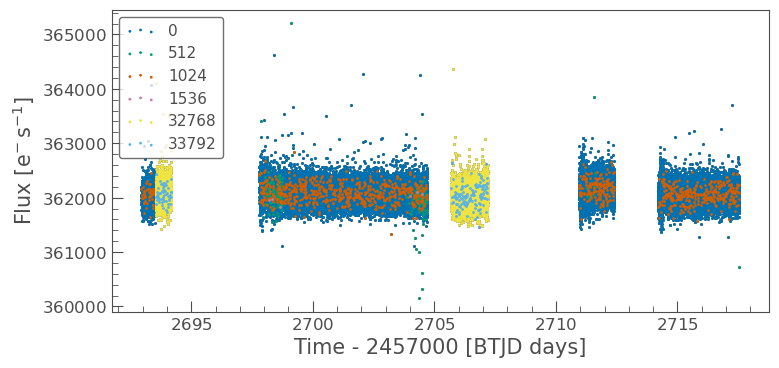

In [21]:
ax = lc.scatter(label='');
for flag in np.unique(lc.quality):
    m = lc.quality == flag
    lc[m].scatter(ax=ax, label=flag);

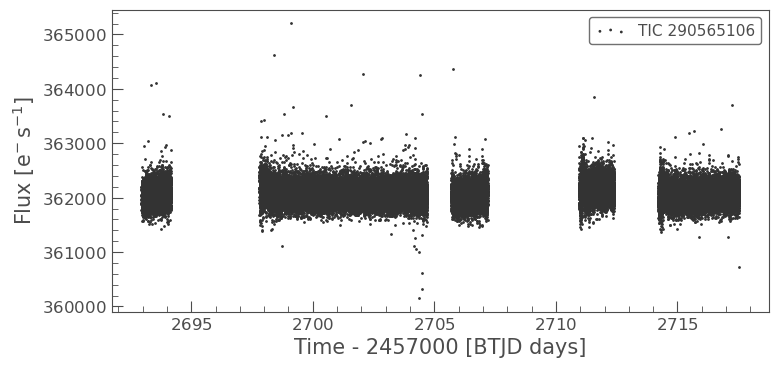

In [22]:
lc.scatter();

In [23]:
flat_lc,trend_lc = lc.flatten(window_length=5001, return_trend = True, break_tolerance=50)

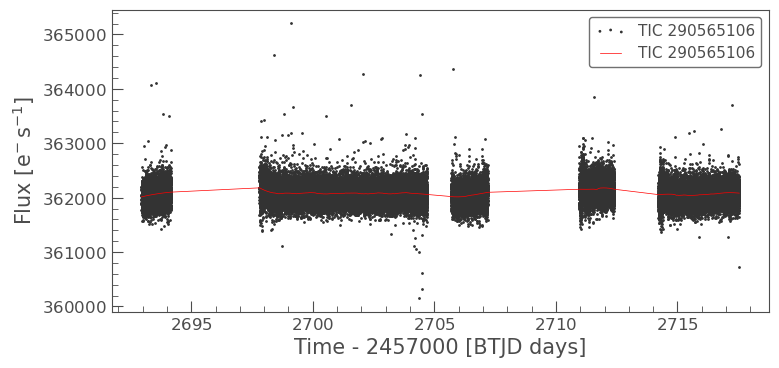

In [24]:
ax = lc.scatter()
trend_lc.plot(ax=ax,c='r');

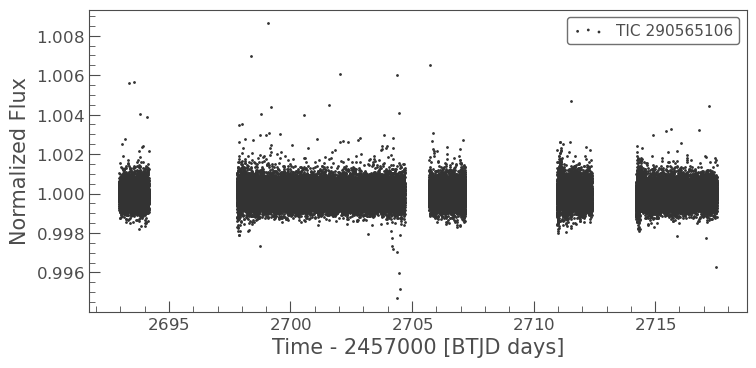

In [25]:
flat_lc.scatter();

In [26]:
lc.to_csv(path_or_buf='lightcurves/HD140283_20s_S51_SYDSAP_corr.csv')
lc.to_fits('lightcurves/HD140283_20s_S51_SYDSAP_corr.fits')

In [27]:
flat_lc.to_csv(path_or_buf='lightcurves/HD140283_20s_S51_SYDSAP_corr_flat.csv')
flat_lc.to_fits('lightcurves/HD140283_20s_S51_SYDSAP_corr_flat.fits')